In [1]:
import pandas as pd

In [6]:
df = pd.read_parquet("measuring-hate-speech.parquet")

In [24]:
df

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,47777,10873,3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
1,39773,2790,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
2,47101,3379,3,4.0,4.0,4.0,4.0,4.0,4.0,0.0,...,False,False,False,False,True,False,False,False,True,False
3,43625,7365,3,2.0,3.0,2.0,1.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
4,12538,488,0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135551,37080,8590,2,1.0,1.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
135552,22986,8303,2,2.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,True,True,False,False,False
135553,21008,6207,2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
135554,22986,7886,2,2.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,True,False,False,False,True,False


In [28]:
df.columns.to_list()
df[df['comment_id']==39773][['text','hate_speech_score']].values

array([['The trans women reading this tweet right now is beautiful',
        -6.52],
       ['The trans women reading this tweet right now is beautiful',
        -6.52],
       ['The trans women reading this tweet right now is beautiful',
        -6.52]], dtype=object)

In [ ]:
df

<AxesSubplot: >

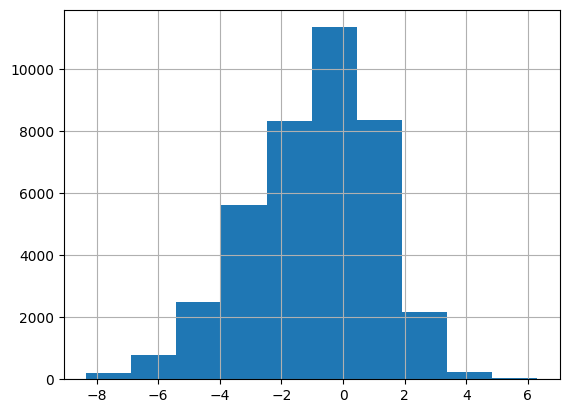

In [22]:
df.groupby("comment_id")['hate_speech_score'].mean().hist()